# Standard imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Explore the data

In [4]:
import os
from PIL import Image
from IPython.display import display

In [13]:
path = 'CATS_DOGS/'

names_of_images = []

for folder,subfolder,imagenames in os.walk(path):
    for image in imagenames:
        names_of_images.append(folder+'/'+image)
    

In [14]:
len(names_of_images)

24994

In [ ]:
image_sizes = []

for item in names_of_images:
    with Image.open(item) as im:
        image_sizes.append(im.size)

In [ ]:
len(image_sizes)

In [34]:
df = pd.DataFrame(image_sizes)
df.head()

,0,1
0,431,360
1,500,375
2,500,471
3,500,375
4,320,240


In [36]:
df.describe()

,0,1
count,24994.000000,24994.000000
mean,404.493518,361.037129
std,108.941802,96.936811
min,42.000000,33.000000
25%,323.000000,302.000000
50%,448.000000,375.000000
75%,500.000000,421.000000
max,500.000000,500.000000


# few things to know

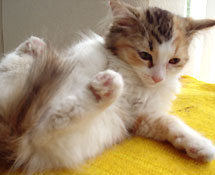

(215, 175)


In [52]:
with Image.open('CATS_DOGS/train/CAT/105.jpg') as image:
    display(image)
    print(image.size)

In [53]:
# image to a tensor [colorchannels, len, height]

trans = transforms.Compose([transforms.ToTensor()])
i = trans(image)
i.shape

torch.Size([3, 175, 215])

In [54]:
image.getpixel((0,0)) 

(105, 96, 81)

In [55]:
i[:,0,0]

#automatic normalization when converted to a tensor (division of the values by '255')

tensor([0.4118, 0.3765, 0.3176])

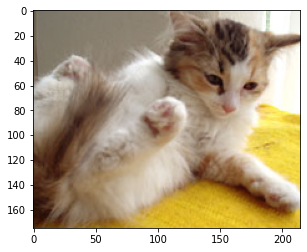

In [47]:
#to print image with matplotlib convert to this format---> [175,215,3]

x = np.transpose(i.numpy(),(1,2,0))
plt.imshow(x)

# -------------------------------------------------------------------------------------------
## How different transformations on images work

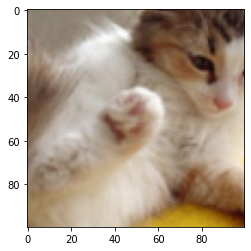

In [58]:
# Resizing and center cropping

trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Resize(140),
                           transforms.CenterCrop(100)])
i = trans(image)
i.shape


plt.imshow(np.transpose(i.numpy(),(1,2,0)))

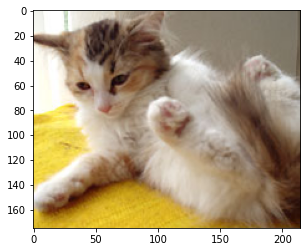

In [60]:
#Horizontal flipping with some probability

trans = transforms.Compose([
                            transforms.RandomHorizontalFlip(p=0.8),
                           transforms.ToTensor()])
i = trans(image)
i.shape


plt.imshow(np.transpose(i.numpy(),(1,2,0)))

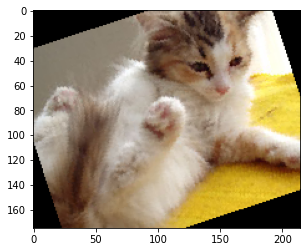

In [64]:
# Rotating by some particular angle

trans = transforms.Compose([
                            transforms.RandomRotation(50),
                           transforms.ToTensor()])
i = trans(image)
i.shape


plt.imshow(np.transpose(i.numpy(),(1,2,0)))

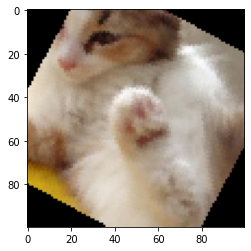

In [67]:
# Different transformations all together

trans = transforms.Compose([ transforms.RandomHorizontalFlip(p=0.8),
                             transforms.Resize(140),
                             transforms.CenterCrop(100),
                             transforms.RandomRotation(30),
                             transforms.ToTensor()])
i = trans(image)
i.shape


plt.imshow(np.transpose(i.numpy(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


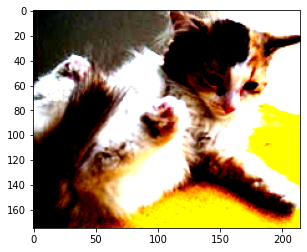

In [70]:
# when using pre trained networks we want to normalize the same way as pre trained networks did

trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
                             ])

i = trans(image)
i.shape


plt.imshow(np.transpose(i.numpy(),(1,2,0)))

# Actual code for CNN

In [5]:
train_transform = transforms.Compose([
        transforms.RandomRotation(15),      
        transforms.RandomHorizontalFlip(),  
        transforms.Resize(224),             
        transforms.CenterCrop(224),         
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [6]:
train_data = datasets.ImageFolder(os.path.join('CATS_DOGS/', 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join('CATS_DOGS/', 'test'), transform=test_transform)

#train and test data are now transformed according to the above transformations

In [7]:
torch.manual_seed(64)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

In [8]:
print(class_names)

['CAT', 'DOG']


In [9]:
print(len(train_data))
print(len(test_data))

18743
6251


In [13]:
for i,(d,l) in enumerate(train_loader):
    break

In [18]:
d.size()

torch.Size([10, 3, 224, 224])

In [15]:
l

tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 1])

# Model

In [10]:
class CNN(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.cl1 = nn.Conv2d(3,6,3,1)        # Input channels is 3 (since we are working with RGB images)
        self.cl2 = nn.Conv2d(6,16,3,1)
        
        
        self.fc1 = nn.Linear(54*54*16,120) 
        
        # (((224-(3-1))/2)-(3-1))/2 = 54 Here 224-->size of the image, 3-->kernel size , division by 2 -->pooling layer of kernelsize=2 is used
        
        self.fc2 = nn.Linear(120,64)
        self.fc3 = nn.Linear(64,2)
        
    def forward(self, X):
        
        X = F.relu(self.cl1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.cl2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)   # Flattening inorder to send to fully connected layer
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)   # returning the probabilities
    

In [11]:
torch.manual_seed(64)
model = CNN()

In [12]:
model

CNN(
  (cl1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (cl2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

# Loss Function and Optimizer selection

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training

In [14]:
import time
start_time = time.time()

epochs = 3

train_losses = []
test_losses = []

train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0
    
    
    for b, (X_train, y_train) in enumerate(train_loader):
            
        b+=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        if b%200 == 0:
            print(f'epoch: {i}  batch: {b:4} [{10*b:6}/{len(train_data)}]  loss: {loss.item():10.8f}  \
accuracy: {train_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append(train_corr)

   
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1] 
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)
    
total_time =(time.time() - start_time)/60
print(f'\nTotal_time: {total_time} minutes') 

epoch: 0  batch:  200 [  2000/18743]  loss: 0.54223973  accuracy:  56.950%
epoch: 0  batch:  400 [  4000/18743]  loss: 0.70405430  accuracy:  60.450%
epoch: 0  batch:  600 [  6000/18743]  loss: 0.93825275  accuracy:  62.100%
epoch: 0  batch:  800 [  8000/18743]  loss: 1.06363213  accuracy:  63.388%
epoch: 0  batch: 1000 [ 10000/18743]  loss: 0.45736498  accuracy:  64.040%
epoch: 0  batch: 1200 [ 12000/18743]  loss: 0.71010560  accuracy:  64.658%
epoch: 0  batch: 1400 [ 14000/18743]  loss: 0.40295115  accuracy:  65.264%
epoch: 0  batch: 1600 [ 16000/18743]  loss: 0.38881737  accuracy:  65.812%
epoch: 0  batch: 1800 [ 18000/18743]  loss: 0.45965996  accuracy:  66.339%
epoch: 1  batch:  200 [  2000/18743]  loss: 0.62539828  accuracy:  73.450%
epoch: 1  batch:  400 [  4000/18743]  loss: 0.50943798  accuracy:  73.000%
epoch: 1  batch:  600 [  6000/18743]  loss: 0.65421808  accuracy:  72.883%
epoch: 1  batch:  800 [  8000/18743]  loss: 0.50736201  accuracy:  72.850%
epoch: 1  batch: 1000 [ 1

# Plots

## Loss vs Epochs

In [142]:
los = [floss.item() for floss in train_losses ]


In [143]:
los

[0.16636034846305847, 0.9031715989112854, 1.0937527418136597]

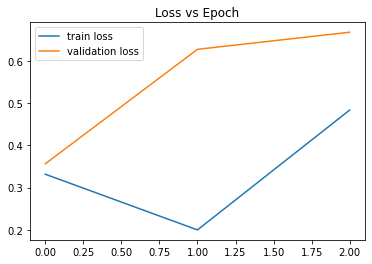

In [15]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss vs Epoch')
plt.legend();

## Train and Test accuracies vs Epochs 

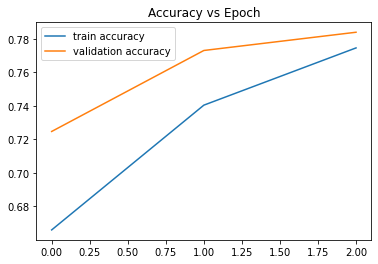

In [16]:
plt.plot([t/len(train_data) for t in train_correct], label='train accuracy')
plt.plot([t/len(test_data) for t in test_correct], label='validation accuracy')
plt.title('Accuracy vs Epoch')
plt.legend();

# Overall Accuracy

In [17]:
# Number of correct predictions on test data at the end of every epoch 

print(test_correct)


[tensor(4530), tensor(4832), tensor(4900)]


In [18]:
# overall Test accuracy after 3 epochs

print(f'Test accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')

Test accuracy: 78.387%
